# Library

In [22]:
import os
import sys
import re
import pickle
import random
import subprocess
import time
import threading
import shutil
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor, wait, ALL_COMPLETED, as_completed
from datetime import datetime, timedelta
from multiprocessing import Process, Pool

import numpy as np
import pandas as pd
import anndata as ad
import h5py
# import Bio
# from Bio import motifs
import pysam
import pyranges
import pybedtools
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import sklearn
from sklearn import preprocessing
import scipy
from scipy import io
import scanpy as sc
from sklearn.cluster import KMeans
from adjustText import adjust_text
# import episcanpy
import ruamel.yaml
yaml = ruamel.yaml.YAML(typ="safe")
yaml.default_flow_style = False


import SCRIPT
from SCRIPT.utilities import utils
from SCRIPT.utilities.utils import print_log, safe_makedirs, excute_info, store_to_pickle, read_pickle

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
# warnings.simplefilter(action='ignore', category=subprocess.)

plt.rcParams.update({
    'figure.figsize': [8.0, 8.0],
    'font.size' : 15,
    'font.family': 'Arial',
    'font.style' : 'normal',
    'font.weight':'bold',
    'figure.titleweight': 'bold',
    'axes.labelsize': 14 ,
    'axes.titleweight': 'normal',
    'axes.labelweight': 'bold',
    'axes.spines.right': False,
    'axes.spines.top': False,
})

N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(220/256, 34/256, N)
vals[:, 1] = np.linspace(220/256, 7/256, N)
vals[:, 2] = np.linspace(220/256, 141/256, N)
regulation_cmp = mpl.colors.ListedColormap(vals)

# Function Define

In [2]:
from sklearn.neighbors import KDTree
from sklearn.neighbors import BallTree

def find_nearest_cells(q_point, tree, n_neighbor):
    _, ind = tree.query(q_point, k=n_neighbor+1)
    return ind[0][1:]

def cal_neighbor_cell_peak_mat(sub_mat, input_mat, tree, pc_table, impute_n, start_idx, i):
    end_index = start_idx + sub_mat.shape[0]
    k = 0
    for idx in range(start_idx, end_index):
        nearest_bc_idx = find_nearest_cells(np.reshape(pc_table[idx,:], (1,-1)), tree, n_neighbor=impute_n)
#         scipy.sparse.csr_matrix(input_mat[nearest_bc_idx,:].sum(0))
        sub_mat[k,:] = input_mat[nearest_bc_idx,:].sum(0)
        k += 1
    return sub_mat

def cal_neighbor_cell_peak_mat_batch(input_mat, impute_n=5, KD_leafsize=80, nPC = 50, n_cores=8):
    '''
    input_mat:
    a csr sparse matrix, which can be get by adata.X
    
    '''
    print_log("Building KD tree...")
    pc_table = sc.tl.pca(input_mat, n_comps=50, svd_solver='arpack')
    tree = BallTree(pc_table, KD_leafsize)
    print_log("Calculating neighbors, divide into {n} chunks...".format(n=n_cores))
    cell_number = input_mat.shape[0]
    index_split = [i for i in range(0,cell_number,int(cell_number/n_cores))] + [cell_number]
#     input_table_split = np.array_split(input_mat_dense, n_cores)
    input_mat_lil = input_mat.tolil()
    input_mat_split = [input_mat_lil[index_split[i]:index_split[i+1],:] for i in range(index_split.__len__()-1)]
    args = [[sub_mat, input_mat, tree, pc_table, impute_n, index_split[i], i] for (i, sub_mat) in enumerate(input_mat_split)]
#     print(args)
    with Pool(n_cores) as p:
        result = p.starmap(cal_neighbor_cell_peak_mat, args)
    cell_peak_csr = scipy.sparse.vstack(result).tocsr()
    print_log('Finished!')
    return cell_peak_csr

In [3]:
def generate_peak_list(cells, input_mat, peak_confidence=1):
    cell_above_cutoff_index = sc.pp.filter_genes(
        input_mat[cells, :], min_cells=peak_confidence, inplace=False)[0]
    peaks = input_mat.var_names[cell_above_cutoff_index].to_list()
    return peaks


def generate_beds(file_path, cells, input_mat, peak_confidence=1):
    peaks = generate_peak_list(cells, input_mat, peak_confidence)
    cell_barcode = os.path.basename(file_path)[:-4]  # remove .bed
    if peaks.__len__() == 0:
        print_log('Warning: No peaks in {bed_path}, skip generation'.format(bed_path=file_path[:-4]))
    else:
        peaks = pd.DataFrame([p.rsplit("_", 2) for p in peaks])
        peaks.to_csv(file_path, sep="\t", header=None, index=None)
        cmd = 'sort --buffer-size 2G -k1,1 -k2,2n -k3,3n {bed_path} | bgzip -c > {bed_path}.gz\n'.format(bed_path=file_path)
        cmd += 'rm {bed_path}'.format(bed_path=file_path)
        subprocess.run(cmd, shell=True, check=True)
    return [cell_barcode, peaks.__len__()]


def generate_beds_by_matrix(cell_feature_adata, beds_path, peaks_number_path, n_cores):
    safe_makedirs(beds_path)
    # total_cnt = adata.obs.index.__len__()
    executor = ThreadPoolExecutor(max_workers=n_cores)
    all_task = []
    for cell in cell_feature_adata.obs.index:
        # neighbor_cells = find_nearest_cells(cell, coor_table, n_neighbor, step)
        # map_dict[cell] = neighbor_cells
        all_task.append(executor.submit(generate_beds, beds_path + "/" + str(cell) + ".bed", cell, cell_feature_adata))
    wait(all_task, return_when=ALL_COMPLETED)
    pd.DataFrame([_.result() for _ in as_completed(all_task)]).to_csv(peaks_number_path, header=None, index=None, sep='\t')
    return



# def generate_beds(file_path, cells, input_mat, sep='_', peak_confidence=1):
#     peaks = generate_peak_list(cells, input_mat, peak_confidence)
#     cell_barcode = os.path.basename(file_path)[:-4]  # remove .bed
#     if peaks.__len__() == 0:
#         print_log('Warning: No peaks in {bed_path}, skip generation'.format(bed_path=file_path[:-4]))
#     else:
#         if len(sep) == 1:
#             peaks = pd.DataFrame([p.rsplit(sep, 2) for p in peaks])
#         else:
#             peaks = pd.DataFrame([[p.split(sep[0])[0], p.split(sep[0])[1].split(sep[1])[0], p.split(sep[0])[1].split(sep[1])[1]] for p in peaks])
#         peaks.to_csv(file_path, sep="\t", header=None, index=None)
#         cmd = 'sort --buffer-size 2G -k1,1 -k2,2n -k3,3n {bed_path} | bgzip -c > {bed_path}.gz\n'.format(bed_path=file_path)
#         cmd += 'rm {bed_path}'.format(bed_path=file_path)
#         subprocess.run(cmd, shell=True, check=True)
#     return [cell_barcode, peaks.__len__()]


# def generate_beds_by_matrix(cell_feature_adata, beds_path, peaks_number_path, sep='_', n_cores=8):
#     safe_makedirs(beds_path)
#     # total_cnt = adata.obs.index.__len__()
#     executor = ThreadPoolExecutor(max_workers=n_cores)
#     all_task = []
#     for cell in cell_feature_adata.obs.index:
#         # neighbor_cells = find_nearest_cells(cell, coor_table, n_neighbor, step)
#         # map_dict[cell] = neighbor_cells
#         all_task.append(executor.submit(generate_beds, beds_path + "/" + str(cell) + ".bed", cell, cell_feature_adata, sep))
#     wait(all_task, return_when=ALL_COMPLETED)
#     pd.DataFrame([_.result() for _ in as_completed(all_task)]).to_csv(peaks_number_path, header=None, index=None, sep='\t')
#     return

In [4]:
def search_seqpare_factor(bed_path, result_path, index_path, factor):
    cmd = 'seqpare "{index_path}/{factor}*.bed.gz" "{bed_path}" -m 1 -o {result_path}\n'.format(
        index_path=index_path, result_path=result_path, bed_path=bed_path, factor=factor)
    subprocess.run(cmd, shell=True, check=True)


def search_seqpare_factor_batch(bed_folder, result_folder, index_path, factor, n_cores=8, tp=''):
    print_log('Start searching beds from {tp} index ...'.format(tp=tp))
    safe_makedirs(result_folder)
    beds = os.listdir(bed_folder)
    args = []
    for bed in beds:
        barcodes = bed[:-7]  # remove suffix '.bed.gz'
        args.append((os.path.join(bed_folder, bed),
                     os.path.join(result_folder, barcodes + '.txt'),
                     index_path,
                     factor))
    with Pool(n_cores) as p:
        p.starmap(search_seqpare_factor, args)
    print_log('Finished searching beds from {tp} index ...'.format(tp=tp))

In [5]:
def get_factor_affinity(input_mat, bed_file_path, reference, factor, ccre_number):
    ref_number = pd.read_csv(reference + '/peaks_number.txt', sep='\t', index_col=0, header=None)
    factor_idx = [i for i in ref_number.index if i.startswith(factor)]
    ref_number = ref_number.loc[factor_idx,:]

    peaks = input_mat.var_names.to_list()
    peaks_number = peaks.__len__()
    peaks = pd.DataFrame([p.rsplit("_", 2) for p in peaks])
    peaks.to_csv(bed_file_path, sep="\t", header=None, index=None)
    cmd = 'sort --buffer-size 2G -k1,1 -k2,2n -k3,3n {bed_path} | bgzip -c > {bed_path}.gz\n'.format(bed_path=bed_file_path)
    cmd += 'rm {bed_path}'.format(bed_path=bed_file_path)
    subprocess.run(cmd, shell=True, check=True)

    search_seqpare_factor(bed_file_path + '.gz', bed_file_path[0:-4] + '.txt', reference, factor)
    all_peak_result = read_seqpare_result([bed_file_path[0:-4] + '.txt'])
    affinity = all_peak_result.iloc[:,0]/(ref_number[1]*peaks_number/ccre_number)
    return affinity

def read_seqpare_result(files):
    for i in range(len(files)):
        giggle_result = os.path.basename(files[i])
        cell_bc = giggle_result[:-4]  # remove suffix '.txt'
        dtframe = pd.read_csv(files[i], sep="\t", index_col=5)
        if i == 0:
            dtframe = dtframe.loc[:, ['teo']].copy()
            dataset_cell_score_df = dtframe.rename(columns={'teo': cell_bc})
        else:
            dataset_cell_score_df[cell_bc] = dtframe.loc[:, "teo"]
    dataset_cell_score_df.index = [i.rsplit('/', 1)[1][:-7] for i in dataset_cell_score_df.index]  # remove suffix '.bed.gz'
    return dataset_cell_score_df

def read_seqpare_result_batch(path, n_cores=8, tp=''):
    print_log("Reading searching results, using {n} cores...".format(n=n_cores))
    file_list = os.listdir(path)
    result_split = np.array_split(file_list, n_cores)
    args = [[[os.path.join(path, j) for j in list_chunk]] for list_chunk in result_split]
    with Pool(n_cores) as p:
        result = p.starmap(read_seqpare_result, args)
    dataset_cell_score_df = pd.concat([i for i in result], axis=1)
    print_log("Finished reading {tp} index search result!".format(tp=tp))
    return dataset_cell_score_df

In [6]:
def cal_peak_factor_norm(ref_peak_number_path, peaks_number_path, ccre_number, affinity, factor):
    ref_peak_number = pd.read_csv(ref_peak_number_path, sep='\t', header=None, index_col=0)
    factor_idx = [i for i in ref_peak_number.index if i.startswith(factor)]
    ref_peak_number = ref_peak_number.loc[factor_idx,:]
    data_peak_number = pd.read_csv(peaks_number_path, sep='\t', header=None, index_col=0)
    peak_norm_hyper = (ref_peak_number.dot(data_peak_number.T)/ccre_number)
    peak_norm_hyper = (peak_norm_hyper.T * affinity).T
    return peak_norm_hyper


def cal_score(dataset_mbm_overlap_df, dataset_bg_peak_norm_df):
    intersect_frame = dataset_mbm_overlap_df.copy()
    peak_hyper_frame = dataset_bg_peak_norm_df.copy().reindex(index=intersect_frame.index, columns=intersect_frame.columns)
    fg_dataset_cell_raw_score_df = np.log2((intersect_frame+1)/(peak_hyper_frame+1))
    return fg_dataset_cell_raw_score_df

In [7]:
@excute_info('Getting the best reference for each cell...')
def get_factor_source(table):
    ret_table = table.copy()
    # map factor by id "_"
    factor_index_list = []
    for i in ret_table.index:
        factor_name = i.split("_")
        factor_index_list.append(factor_name[0])
    ret_table.loc[:, "Factor"] = factor_index_list
    max_index = ret_table.groupby("Factor").idxmax()
    return max_index

In [8]:
def write_to_mtx(data, path):
    if not os.path.exists(path):
        os.makedirs(path)
    pd.DataFrame(data.var.index).to_csv(os.path.join(path, "genes.tsv" ), sep = "\t", index=False, header=False)
    pd.DataFrame(data.obs.index).to_csv(os.path.join(path, "barcodes.tsv"), sep = "\t", index=False, header=False)
    data.obs.to_csv(os.path.join(path, "metadata.tsv"), sep = "\t", index=False, header=False)
    io.mmwrite(os.path.join(path, "matrix.mtx"), data.X.T)

In [9]:
def geneInfoSimple(gene_bed):
    genes_info = []
    genes_list = []
    fhd = open(gene_bed, 'rt')
    fhd.readline() # skip the first line. In our current gene txt file, there is no '#' in the first line. We need to, perhaps, use the 'ExtractGeneInfo' function.
    for line in fhd:
        line = line.strip().split('\t')
        if not line[0].startswith('#'):
            if line[3] == "+":
                genes_info.append((line[2].replace('chr',''), int(line[4]), 1, "%s@%s@%s" % (line[12], line[2], line[4])))
            else:
                genes_info.append((line[2].replace('chr',''), int(line[5]), 1, "%s@%s@%s" % (line[12], line[2], line[5])))
                # gene_info [chrom, tss, 1, gene_unique]
    fhd.close()
    genes_info = list(set(genes_info))
    for igene in range(len(genes_info)):
        tmp_gene = list(genes_info[igene])
        genes_list.append(tmp_gene[3])
        tmp_gene[3] = igene
        genes_info[igene] = tmp_gene
    return genes_info, genes_list

def RP_Simple(peaks_info, genes_info, decay):
    """Multiple processing function to calculate regulation potential."""

    Sg = lambda x: 2**(-x)
    gene_distance = 15 * decay
    genes_peaks_score_array = scipy.sparse.dok_matrix((len(genes_info), len(peaks_info)), dtype=np.float64)

    w = genes_info + peaks_info

    A = {}

    w.sort()
    for elem in w:
        if elem[2] == 1:
            A[elem[-1]] = [elem[0], elem[1]]
        else:
            dlist = []
            for gene_name in list(A.keys()):
                g = A[gene_name]
                tmp_distance = abs(elem[1] - g[1])
                if (g[0] != elem[0]) or (tmp_distance > gene_distance):
                    dlist.append(gene_name)
                else:
                    genes_peaks_score_array[gene_name, elem[-1]] = Sg(tmp_distance / decay)
            for gene_name in dlist:
                del A[gene_name]

    w.reverse()
    for elem in w:
        if elem[2] == 1:
            A[elem[-1]] = [elem[0], elem[1]]
        else:
            dlist = []
            for gene_name in list(A.keys()):
                g = A[gene_name]
                tmp_distance = abs(g[1] - elem[1])
                if (g[0] != elem[0]) or (tmp_distance > gene_distance):
                    dlist.append(gene_name)
                else:
                    genes_peaks_score_array[gene_name, elem[-1]] = Sg(tmp_distance / decay)
            for gene_name in dlist:
                del A[gene_name]

    return genes_peaks_score_array

In [10]:
def enhance(input_mat, impute_n=5, KD_leafsize=80, nPC = 50, path='SCRIPT/enhancement/', binarize=True, n_cores=8):
    '''
    input_mat:
    a csr sparse matrix
    
    '''
    safe_makedirs(path)
    imputed_csr = cal_neighbor_cell_peak_mat_batch(input_mat, impute_n=impute_n, KD_leafsize=KD_leafsize, nPC = nPC, n_cores=n_cores)
    if binarize == True:
        imputed_csr[imputed_csr>1] = 1
    utils.store_to_pickle(imputed_csr, path + 'imputed.csr.pk')
    return imputed_csr


def impute(input_mat_adata, impute_factor, ref_path, bed_check=True, search_check=True, ccre_number=339815, path='SCRIPT/imputation/', write_mtx=True, ref_baseline=5000, remove_others_source=False, n_cores=8):
    '''
    ccre_number, mouse for 339815
    '''
    
    safe_makedirs(path)
    print(input_mat_adata.X.shape)
    if bed_check == True:
        if not os.path.exists(path + '/imputed_beds/'):
            print_log('Generating beds...')
            generate_beds_by_matrix(input_mat_adata, path + '/imputed_beds/', path + '/imputed_beds_peaks_number.txt', n_cores)
        else:
            print_log('Skip generate beds...')
    else:
        print_log('Generating beds...')
        generate_beds_by_matrix(input_mat_adata, path + '/imputed_beds/', path + '/imputed_beds_peaks_number.txt', n_cores)
    
    if search_check == True:
        if not os.path.exists(path + '/imputed_results_%s/' % impute_factor):
            search_seqpare_factor_batch(path + '/imputed_beds/', path + '/imputed_results_%s/' % impute_factor, ref_path, impute_factor, n_cores)
        else:
            print_log('Skip searching beds...')
    else:
        search_seqpare_factor_batch(path + '/imputed_beds/', path + '/imputed_results_%s/' % impute_factor, ref_path, impute_factor, n_cores)
    
    print_log('Calculating score...')
    factor_affinity = get_factor_affinity(input_mat_adata,  path + '/all_beds.bed', ref_path, impute_factor, ccre_number)
    factor_enrich = read_seqpare_result_batch(path + '/imputed_results_%s/' % impute_factor, n_cores)
    factor_hyper_bg = cal_peak_factor_norm(ref_path + 'peaks_number.txt',  path + '/imputed_beds_peaks_number.txt', ccre_number, factor_affinity, impute_factor)
    factor_score = cal_score(factor_enrich, factor_hyper_bg)
    
    ref_peak_number = pd.read_csv(ref_path + '/peaks_number.txt', sep='\t', header=None, index_col=0)
    factor_idx = [i for i in ref_peak_number.index if i.startswith(impute_factor)]
    ref_peak_number = ref_peak_number.loc[factor_idx,:]
    
    factor_score = factor_score.loc[ref_peak_number.index[ref_peak_number[1] > ref_baseline],:].copy()
    factor_source = get_factor_source(factor_score)
    store_to_pickle(factor_source, path + '%s_dataset_source.pk' % impute_factor)
    
    chip_bed_list = [pybedtools.BedTool(os.path.join(ref_path, i + '.bed.gz')) for i in factor_source.iloc[0,:].unique()]
    chip_bed = chip_bed_list[0].cat(*chip_bed_list[1:])
    data_bed = pybedtools.BedTool('\n'.join(['\t'.join(p.rsplit('_', maxsplit=2)) for p in input_mat_adata.var_names]), from_string=True)
    intersect_bed = data_bed.intersect(chip_bed, u=True)
    imputed_chip_peak = str(intersect_bed).replace('\t','_').split('\n')[0:-1]
    
    chip_cell_peak = input_mat_adata[:,imputed_chip_peak].copy()
    chip_cell_peak_df = chip_cell_peak.to_df()
    if remove_others_source == True:
        for i in factor_source.iloc[0,:].unique():
            cellbc = factor_source.columns[factor_source.iloc[0,:] == i]
            tmp_dataset_bed = pybedtools.BedTool(os.path.join(ref_path, i + '.bed.gz'))
            exclude_chip_peak = str(intersect_bed.intersect(tmp_dataset_bed, v=True)).replace('\t','_').split('\n')[0:-1]
            chip_cell_peak_df.loc[cellbc,exclude_chip_peak] = 0
    chip_cell_peak = sc.AnnData(chip_cell_peak_df)
    chip_cell_peak.X = scipy.sparse.csr.csr_matrix(chip_cell_peak.X)
    print_log('Writing results...')
    if write_mtx == True:
        write_to_mtx(chip_cell_peak, path + '/imputed_%s_mtx/' % impute_factor)
    print_log('Finished!')
    return chip_cell_peak

def count_to_gene_by_RP(input_adata, decay=100000, refgene_path='/fs/home/dongxin/Files/GRCm38_refgenes.txt',   ):
    cells_list = input_adata.obs.index.tolist()
    peaks_list = input_adata.var.index.tolist()

    genes_info, genes_list= geneInfoSimple(refgene_path)

    peaks_info = []
    for ipeak, peak in enumerate(peaks_list):
        peaks_tmp = peak.rsplit("_", maxsplit=2)
        peaks_info.append([peaks_tmp[0][3:], (int(peaks_tmp[1]) + int(peaks_tmp[2])) / 2.0, 0, ipeak])

    genes_peaks_score_dok = RP_Simple(peaks_info, genes_info, decay)

    genes_peaks_score_csr = genes_peaks_score_dok.tocsr()
    genes_cells_score_csr = genes_peaks_score_csr.dot(chip_cell_peak.X.T)

    score_cells_dict = {}
    score_cells_sum_dict = {}

    for igene, gene in enumerate(genes_list):
        score_cells_dict[gene] = igene
        score_cells_sum_dict[gene] = genes_cells_score_csr[igene, :].sum()

    score_cells_dict_dedup = {}
    score_cells_dict_max = {}
    genes = list(set([i.split("@")[0] for i in genes_list]))
    for gene in genes:
        score_cells_dict_max[gene] = float("-inf")

    for gene in genes_list:
        symbol = gene.split("@")[0]
        if score_cells_sum_dict[gene] > score_cells_dict_max[symbol]:
            score_cells_dict_dedup[symbol] = score_cells_dict[gene]
            score_cells_dict_max[symbol] = score_cells_sum_dict[gene]
    gene_symbol = sorted(score_cells_dict_dedup.keys())
    matrix_row = []
    for gene in gene_symbol:
        matrix_row.append(score_cells_dict_dedup[gene])

    score_cells_matrix = genes_cells_score_csr[matrix_row, :]

    RP_adata = ad.AnnData(score_cells_matrix.T, obs=pd.DataFrame(index=cells_list.tolist()), var =pd.DataFrame(index=gene_symbol))
    return RP_adata
    

# ATAC

## 10X ATAC

First, we process the ATAC dataset from peak count matrix, h5 file downloaded from https://www.10xgenomics.com/resources/datasets/fresh-cortex-from-adult-mouse-brain-p-50-1-standard-1-2-0  
Use MAESTRO, code can be found in `histone_peak_R.ipynb`.

In [11]:
metadata = pd.read_csv('example/histone/peak_base/10X/ATAC_analysis/ATAC_meta_data.txt', sep='\t', index_col = 0)

In [12]:
replace_dict = {
    'L5a Batf3': 'Excitatory neurons',
    'L5b Tph2': 'Excitatory neurons',
    'L2/3 Ptgs2': 'Excitatory neurons',
    'L6b Serpinb11': 'Excitatory neurons',
    'L6a Mgp': 'Excitatory neurons', 
    'L6a Sla': 'Excitatory neurons', 
    'L4 Scnn1a': 'Excitatory neurons', 
    'Micro Ctss': 'Microglia', 
    'Oligo Opalin': 'Oligodendrocytes',
    'OPC Pdgfra': 'OPC', 
    'Astro Aqp4': 'Astrocytes', 
    'Vip Gpc3': 'Vip', 
    'Pvalb Wt1': 'Pvalb', 
    'Others': 'Others'
}


replace_dict = {
    'L5a Batf3': 'NEU',
    'L5b Tph2': 'NEU',
    'L2/3 Ptgs2': 'NEU',
    'L6b Serpinb11': 'NEU',
    'L6a Mgp': 'NEU', 
    'L6a Sla': 'NEU', 
    'L4 Scnn1a': 'NEU', 
    'Micro Ctss': 'MGL', 
    'Oligo Opalin': 'MOL',
    'OPC Pdgfra': 'OPC', 
    'Astro Aqp4': 'AST', 
    'Vip Gpc3': 'NEU', 
    'Pvalb Wt1': 'NEU', 
    'Others': 'NEU'
}

In [13]:
metadata['CellType'] = [replace_dict[i] for i in metadata['assign.ident']]

In [274]:
ATAC = utils.read_SingleCellExperiment_rds('example/histone/peak_base/10X/ATAC_analysis/ATAC_SE.rds')
ATAC.var.index = [i.replace('-', '_') for i in ATAC.var.index]
ATAC.var.index = [i.replace(':', '_') for i in ATAC.var.index]
ATAC.obs['Annotation'] = metadata['CellType'][ATAC.obs.index]
ATAC.obs['ident'] = metadata['assign.ident'][ATAC.obs.index]
ATAC.obs.columns = [str(i) for i in ATAC.obs.columns]
ATAC.obs['nFeature_ATAC'] = ATAC.obs['nFeature_ATAC'].astype(int)
ATAC.write_h5ad('example/histone/peak_base/10X/ATAC_analysis/ATAC_SE.h5ad')

/fs/home/dongxin/Applications/miniconda3/envs/script/lib/python3.9/site-packages/anndata-0.7.6-py3.9.egg/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'ident' as categorical
/fs/home/dongxin/Applications/miniconda3/envs/script/lib/python3.9/site-packages/anndata-0.7.6-py3.9.egg/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Annotation' as categorical


In [14]:
ATAC = sc.read_h5ad('example/histone/peak_base/10X/ATAC_analysis/ATAC_SE.h5ad')

In [ ]:
ATAC

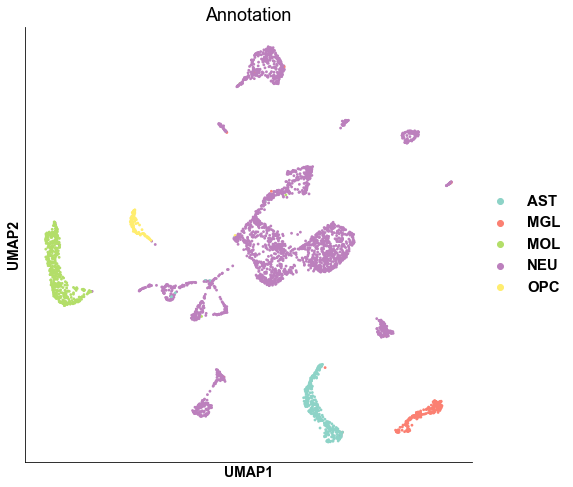

In [15]:
sc.pl.umap(ATAC, color='Annotation', palette='Set3')

In [16]:
for i in ATAC.obs['Annotation'].unique():
    locals()[i+'_barcode'] = ATAC.obs.index[ATAC.obs['Annotation'] == i].tolist()

In [17]:
subATAC = ATAC[AST_barcode + OPC_barcode + MOL_barcode,:].copy()

In [18]:
sc.pp.filter_genes(subATAC,min_cells=10)

In [39]:
ATAC.obs.to_csv('example/histone/peak_base/10X/ATAC_analysis/metadata.txt')

In [20]:
chip_cell_peak_H3K27ac = impute(subATAC, 'H3K27ac', '/fs/home/dongxin/Projects/SCRIPT/indices/mouse/hm_chip_qc_5fold/', 
                         bed_check=True, search_check=True, ccre_number=339815, path='example/histone/peak_base/10X/SCRIPT/imputation_AST_OPC_MOL/', write_mtx=True, ref_baseline=5000, remove_others_source=False, n_cores=64)

(917, 74586)
INFO 2021-09-26 16:25:42 Generating beds...


/fs/home/dongxin/Applications/miniconda3/envs/script/lib/python3.9/site-packages/pandas-1.3.0rc1-py3.9-linux-x86_64.egg/pandas/core/frame.py:3602: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


INFO 2021-09-26 16:26:54 Start searching beds from  index ...
INFO 2021-09-26 16:27:45 Finished searching beds from  index ...
INFO 2021-09-26 16:27:45 Calculating score...
INFO 2021-09-26 16:27:49 Reading searching results, using 64 cores...
INFO 2021-09-26 16:27:50 Finished reading  index search result!
INFO 2021-09-26 16:27:50 Getting the best reference for each cell...
INFO 2021-09-26 16:27:52 Writing results...
INFO 2021-09-26 16:27:56 Finished!


In [21]:
chip_cell_peak_H3K27ac

AnnData object with n_obs × n_vars = 917 × 14294

In [23]:
factor_source = read_pickle('example/histone/peak_base/10X/SCRIPT/imputation_AST_OPC_MOL/H3K27ac_dataset_source.pk')

In [24]:
factor_source.T['H3K27ac'].unique()

array(['H3K27ac_50786', 'H3K27ac_62125', 'H3K27ac_66988', 'H3K27ac_50781',
       'H3K27ac_66466', 'H3K27ac_50746', 'H3K27ac_50751', 'H3K27ac_67045',
       'H3K27ac_35563', 'H3K27ac_85576', 'H3K27ac_88018', 'H3K27ac_49356',
       'H3K27ac_49357', 'H3K27ac_55475', 'H3K27ac_50748', 'H3K27ac_67117',
       'H3K27ac_50757', 'H3K27ac_62127', 'H3K27ac_85594', 'H3K27ac_62126'],
      dtype=object)

In [ ]:
chip_cell_peak_H3K27ac

In [30]:
ATAC.obs['Source'] = 'NA'
ATAC.obs.loc[subATAC.obs.index,'Source'] = factor_source.T['H3K27ac'][subATAC.obs.index]

In [ ]:
ATAC.obs

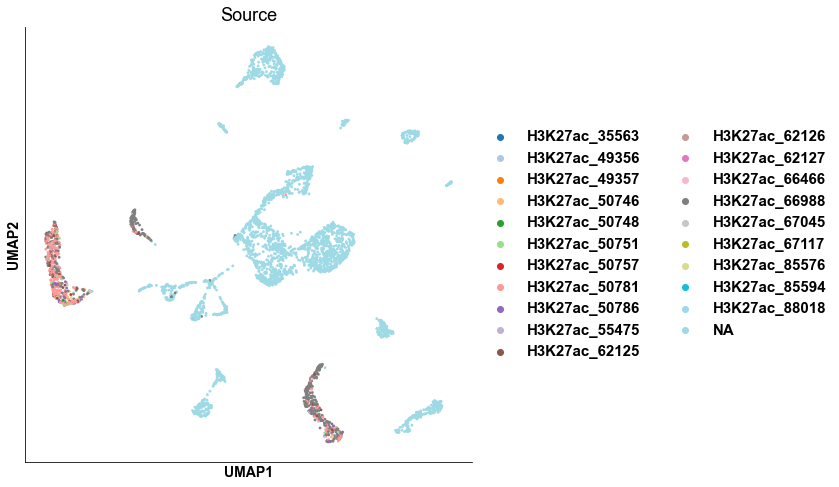

In [33]:
sc.pl.umap(ATAC, color='Source', palette='tab20')

In [37]:
chip_cell_peak_H3K27ac

AnnData object with n_obs × n_vars = 917 × 14294

### enhance

In [ ]:
imputed_csr = enhance(input_mat, impute_n=5, KD_leafsize=80, nPC = 50, path='SCRIPT/enhancement/', binarize=True, n_cores=64)

In [117]:
imputed_csr = utils.read_pickle(path + 'imputed.csr.pk')

In [118]:
imputed_csr[imputed_csr>1] = 1

In [124]:
input_mat_adata.X = imputed_csr

In [125]:
input_mat_adata

AnnData object with n_obs × n_vars = 3814 × 169121
    obs: 'orig.ident', 'nCount_ATAC', 'nFeature_ATAC', 'ATAC_snn_res.0.6', 'seurat_clusters', 'ident', 'Annotation'
    uns: 'Annotation_colors'
    obsm: 'LSI', 'X_umap'
    layers: 'logcounts'

In [134]:
chip_cell_peak_H3K27ac = impute(input_mat_adata, 'H3K27ac', '/fs/home/dongxin/Projects/SCRIPT/indices/mouse/hm_chip_qc_5fold/', 
                        bed_check=True, search_check=True, ccre_number=339815, path='example/histone/peak_base/10X/SCRIPT/imputation/', write_mtx=True, ref_baseline=5000, remove_others_source=False, n_cores=64)

INFO 2021-09-22 20:04:23 Skip generate beds...
INFO 2021-09-22 20:04:23 Skip searching beds...
INFO 2021-09-22 20:04:23 Calculating score...
INFO 2021-09-22 20:05:58 Reading searching results, using 8 cores...
INFO 2021-09-22 20:06:12 Finished reading  index search result!
INFO 2021-09-22 20:06:13 Getting the best reference for each cell.
INFO 2021-09-22 20:06:13 Finding the best reference...
INFO 2021-09-22 20:06:38 Writing results...
INFO 2021-09-22 20:07:43 Finished!


In [138]:
input_mat_adata

AnnData object with n_obs × n_vars = 3814 × 169121
    obs: 'orig.ident', 'nCount_ATAC', 'nFeature_ATAC', 'ATAC_snn_res.0.6', 'seurat_clusters', 'ident', 'Annotation'
    uns: 'Annotation_colors'
    obsm: 'LSI', 'X_umap'
    layers: 'logcounts'

In [168]:
chip_cell_peak_H3K27ac

- after this step, we process this data in R by MAESTRO

In [171]:
ATAC = utils.read_SingleCellExperiment_rds('example/histone/peak_base/10X/SCRIPT/impute_ATAC_analysis_H3K27ac/ATAC_SE.rds')
ATAC.var.index = [i.replace('-', '_') for i in ATAC.var.index]
ATAC.var.index = [i.replace(':', '_') for i in ATAC.var.index]
ATAC.obs['Annotation'] = metadata['CellType'][ATAC.obs.index]
ATAC.obs['ident'] = metadata['assign.ident'][ATAC.obs.index]

In [174]:
ATAC.obs['Source'] = factor_source.T['H3K27ac'][ATAC.obs.index]

/fs/home/dongxin/Applications/miniconda3/envs/script/lib/python3.9/site-packages/anndata-0.7.6-py3.9.egg/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'ident' as categorical
/fs/home/dongxin/Applications/miniconda3/envs/script/lib/python3.9/site-packages/anndata-0.7.6-py3.9.egg/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Annotation' as categorical


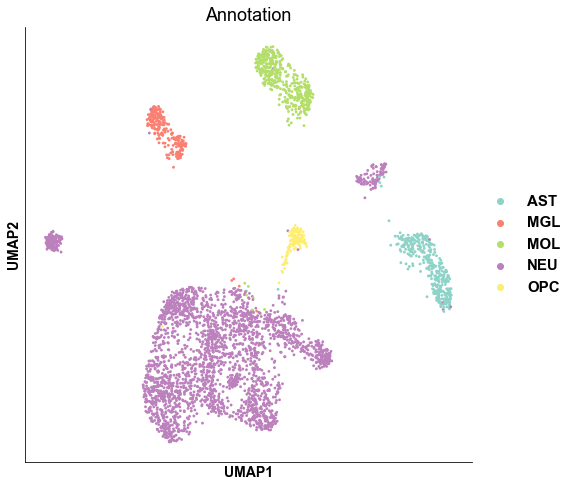

In [172]:
sc.pl.umap(ATAC, color='Annotation', palette='Set3')

/fs/home/dongxin/Applications/miniconda3/envs/script/lib/python3.9/site-packages/anndata-0.7.6-py3.9.egg/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Source' as categorical


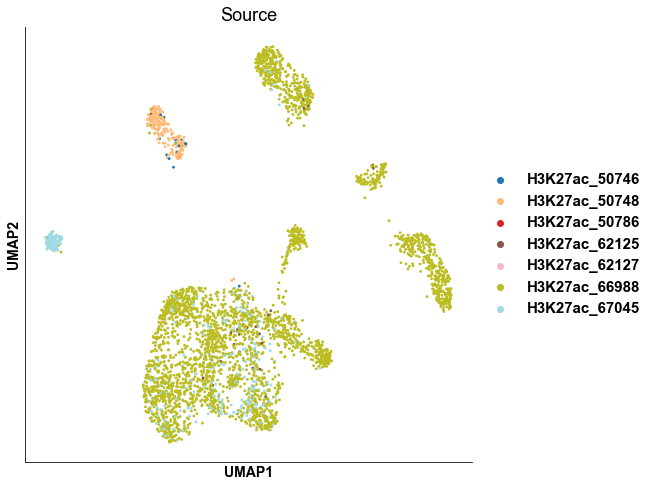

In [175]:
sc.pl.umap(ATAC, color='Source', palette='tab20')

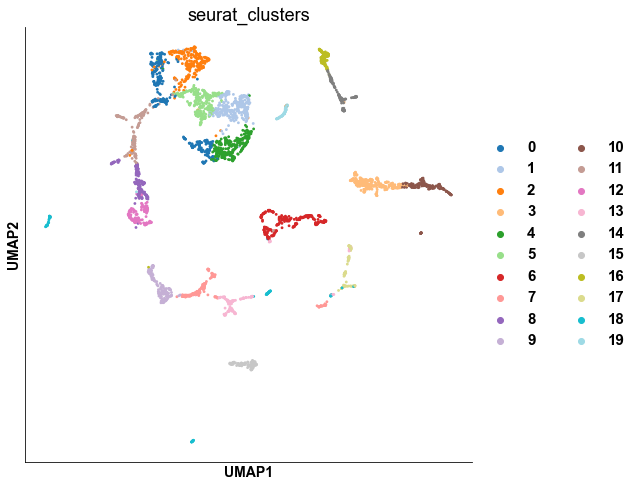

In [71]:
sc.pl.umap(ATAC, color='seurat_clusters', palette='tab20')

In [57]:
chip_cell_peak

AnnData object with n_obs × n_vars = 3814 × 12519

In [62]:
cells_list = chip_cell_peak.obs.index

peaks_list = chip_cell_peak.var.index.tolist()

genes_info, genes_list= geneInfoSimple('/fs/home/dongxin/Files/GRCm38_refgenes.txt')

peaks_info = []
for ipeak, peak in enumerate(peaks_list):
    peaks_tmp = peak.rsplit("_", maxsplit=2)
    peaks_info.append([peaks_tmp[0][3:], (int(peaks_tmp[1]) + int(peaks_tmp[2])) / 2.0, 0, ipeak])

genes_peaks_score_dok = RP_Simple(peaks_info, genes_info, 100000)

genes_peaks_score_csr = genes_peaks_score_dok.tocsr()
genes_cells_score_csr = genes_peaks_score_csr.dot(chip_cell_peak.X.T)

score_cells_dict = {}
score_cells_sum_dict = {}

for igene, gene in enumerate(genes_list):
    score_cells_dict[gene] = igene
    score_cells_sum_dict[gene] = genes_cells_score_csr[igene, :].sum()

score_cells_dict_dedup = {}
score_cells_dict_max = {}
genes = list(set([i.split("@")[0] for i in genes_list]))
for gene in genes:
    score_cells_dict_max[gene] = float("-inf")

for gene in genes_list:
    symbol = gene.split("@")[0]
    if score_cells_sum_dict[gene] > score_cells_dict_max[symbol]:
        score_cells_dict_dedup[symbol] = score_cells_dict[gene]
        score_cells_dict_max[symbol] = score_cells_sum_dict[gene]
gene_symbol = sorted(score_cells_dict_dedup.keys())
matrix_row = []
for gene in gene_symbol:
    matrix_row.append(score_cells_dict_dedup[gene])

score_cells_matrix = genes_cells_score_csr[matrix_row, :]

RP_adata = ad.AnnData(score_cells_matrix.T, obs=pd.DataFrame(index=cells_list.tolist()), var =pd.DataFrame(index=genes))

In [64]:
RP_adata.write_h5ad('example/histone/peak_base/10X/SCRIPT/RP_H3K27ac.h5ad')

In [19]:
RP_adata = ad.read_h5ad('example/histone/peak_base/10X/SCRIPT/RP_H3K27ac.h5ad')

In [22]:
sc.pp.filter_genes(RP_adata, min_cells=3)

sc.pp.normalize_total(RP_adata, target_sum=1e4)

sc.pp.log1p(RP_adata)

sc.pp.highly_variable_genes(RP_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

sc.tl.pca(RP_adata, svd_solver='arpack', use_highly_variable=True)
sc.pl.pca_variance_ratio(RP_adata, log=True)
sc.pp.neighbors(RP_adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(RP_adata)
sc.tl.louvain(RP_adata, resolution=0.6)

In [70]:
RP_adata.obs['Annotation'] = metadata['CellType'][RP_adata.obs.index]
RP_adata.obs['ident'] = metadata['assign.ident'][RP_adata.obs.index]

/fs/home/dongxin/Applications/miniconda3/envs/script/lib/python3.9/site-packages/anndata-0.7.6-py3.9.egg/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'Annotation' as categorical
/fs/home/dongxin/Applications/miniconda3/envs/script/lib/python3.9/site-packages/anndata-0.7.6-py3.9.egg/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'ident' as categorical


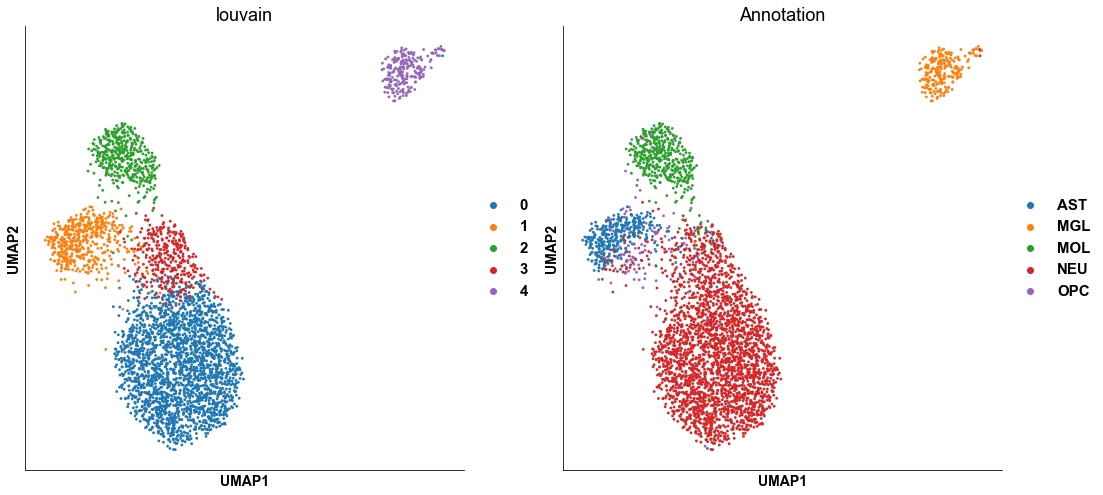

In [71]:
sc.pl.umap(RP_adata, color=['louvain','Annotation'])

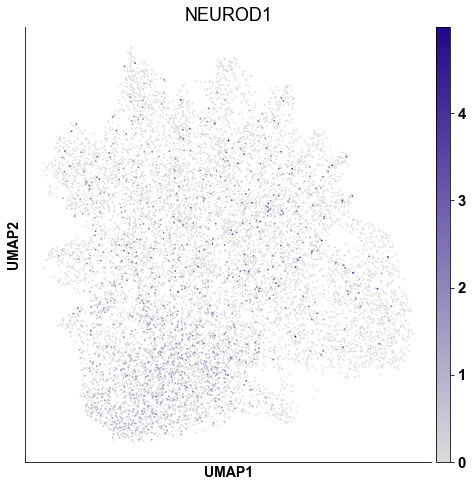

In [255]:
sc.pl.umap(RP_adata, color='NEUROD1', color_map=regulation_cmp)

In [246]:
tmp = sc.read_10x_h5('/fs/home/dongxin/Projects/SCRIPT/scATAC/example/BCC/mtx_new/BCC_peak_count.h5', gex_only=False)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [228]:
H3K27ac_real = utils.read_SingleCellExperiment_rds('example/histone/peak_base/GSE157637_mouse_brain/H3K27ac_SingleCellExperiment.Rds')

In [63]:
H3K27ac_real.obs

Index(['orig.ident', 'nCount_bins_5000', 'nFeature_bins_5000', 'barcode',
       'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq',
       'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode',
       'TSS_fragments', 'DNase_sensitive_region_fragments',
       'enhancer_region_fragments', 'promoter_region_fragments',
       'on_target_fragments', 'blacklist_region_fragments',
       'peak_region_fragments', 'peak_region_cutsites', 'logUMI',
       'promoter_ratio', 'peak_region_ratio', 'all_unique_MB', 'peak_MB',
       'peak_ratio_MB', 'sample', 'passedMB', 'nCount_peaks', 'nFeature_peaks',
       'blacklist_ratio', 'antibody', 'GFP', 'Age', 'nCount_GA', 'nFeature_GA',
       'bins_5000_snn_res.0.3', 'seurat_clusters', 'nCount_PA', 'nFeature_PA',
       'bins_5000_snn_res.0.2', 'marker_Astrocytes', 'marker_OEC',
       'marker_VEC', 'marker_Oligodendrocytes', 'marker_Pericytes',
       'marker_OPC', 'marker_VLMC', 'marker_COP.NFOL', 'cell_type', 'ident'],
      dtype=

In [229]:
sc.pp.filter_genes(H3K27ac_real, min_cells=30)

In [250]:
statis = pd.read_csv('example/histone/peak_base/centerDeviation_realLength_imputeLength.txt', sep=' ', header=None)

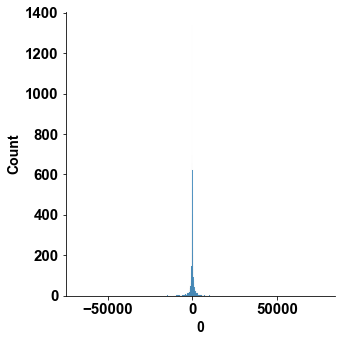

In [252]:
sns.displot(statis[0])

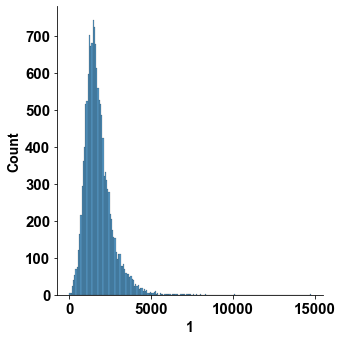

In [253]:
sns.displot(statis[1])

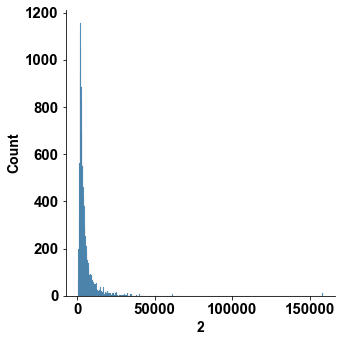

In [254]:
sns.displot(statis[2])

In [238]:
peaks = chip_cell_peak_H3K27ac.var_names.to_list()
peaks_number = peaks.__len__()
peaks = pd.DataFrame([p.rsplit("_", 2) for p in peaks])
peaks.to_csv('example/histone/peak_base/imputed.bed', sep="\t", header=None, index=None)
cmd = 'sort --buffer-size 2G -k1,1 -k2,2n -k3,3n {bed_path} | bgzip -c > {bed_path}.gz\n'.format(bed_path='example/histone/peak_base/imputed.bed')
cmd += 'rm {bed_path}'.format(bed_path='example/histone/peak_base/imputed.bed')
subprocess.run(cmd, shell=True, check=True)

CompletedProcess(args='sort --buffer-size 2G -k1,1 -k2,2n -k3,3n example/histone/peak_base/imputed.bed | bgzip -c > example/histone/peak_base/imputed.bed.gz\nrm example/histone/peak_base/imputed.bed', returncode=0)

In [239]:
peaks = H3K27ac_real.var_names.to_list()
peaks_number = peaks.__len__()
peaks = pd.DataFrame([p.rsplit("-", 2) for p in peaks])
peaks.to_csv('example/histone/peak_base/real.bed', sep="\t", header=None, index=None)
cmd = 'sort --buffer-size 2G -k1,1 -k2,2n -k3,3n {bed_path} | bgzip -c > {bed_path}.gz\n'.format(bed_path='example/histone/peak_base/real.bed')
cmd += 'rm {bed_path}'.format(bed_path='example/histone/peak_base/real.bed')
subprocess.run(cmd, shell=True, check=True)

CompletedProcess(args='sort --buffer-size 2G -k1,1 -k2,2n -k3,3n example/histone/peak_base/real.bed | bgzip -c > example/histone/peak_base/real.bed.gz\n', returncode=0)

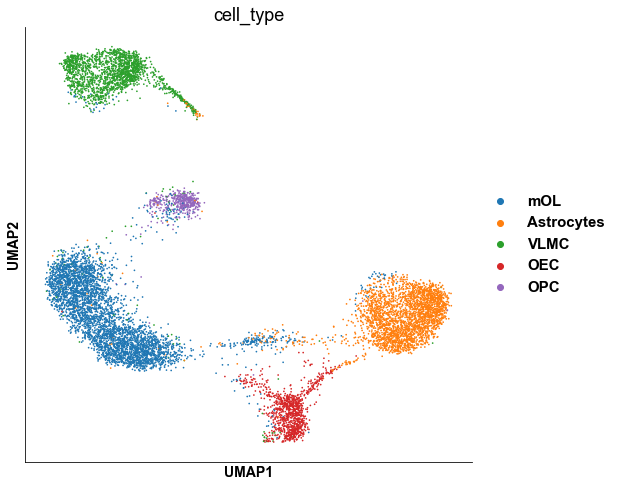

In [17]:
sc.pl.umap(H3K27ac_real, color='cell_type')

In [35]:
H3K27ac_real_df = H3K27ac_real.to_df()

In [ ]:
cells_list

In [36]:
cells_list = H3K27ac_real.obs.index

In [39]:
peaks_list = H3K27ac_real.var.index.tolist()

In [40]:
genes_info, genes_list= geneInfoSimple('/fs/home/dongxin/Files/GRCm38_refgenes.txt')

In [42]:
peaks_info = []
for ipeak, peak in enumerate(peaks_list):
    peaks_tmp = peak.rsplit("-", maxsplit=2)
    peaks_info.append([peaks_tmp[0][3:], (int(peaks_tmp[1]) + int(peaks_tmp[2])) / 2.0, 0, ipeak])

In [44]:
genes_peaks_score_dok = RP_Simple(peaks_info, genes_info, 100000)

genes_peaks_score_csr = genes_peaks_score_dok.tocsr()
genes_cells_score_csr = genes_peaks_score_csr.dot(H3K27ac_real.X.T)

In [45]:
score_cells_dict = {}
score_cells_sum_dict = {}

for igene, gene in enumerate(genes_list):
    score_cells_dict[gene] = igene
    score_cells_sum_dict[gene] = genes_cells_score_csr[igene, :].sum()

score_cells_dict_dedup = {}
score_cells_dict_max = {}
genes = list(set([i.split("@")[0] for i in genes_list]))
for gene in genes:
    score_cells_dict_max[gene] = float("-inf")

for gene in genes_list:
    symbol = gene.split("@")[0]
    if score_cells_sum_dict[gene] > score_cells_dict_max[symbol]:
        score_cells_dict_dedup[symbol] = score_cells_dict[gene]
        score_cells_dict_max[symbol] = score_cells_sum_dict[gene]
gene_symbol = sorted(score_cells_dict_dedup.keys())
matrix_row = []
for gene in gene_symbol:
    matrix_row.append(score_cells_dict_dedup[gene])

score_cells_matrix = genes_cells_score_csr[matrix_row, :]

In [ ]:
gene_symbol

In [57]:
RP_adata = ad.AnnData(score_cells_matrix.T, obs=pd.DataFrame(index=cells_list.tolist()), var =pd.DataFrame(index=gene_symbol))

In [51]:
genes_peaks_score_dok

<38074x84989 sparse matrix of type '<class 'numpy.float64'>'
	with 2769660 stored elements in Dictionary Of Keys format>

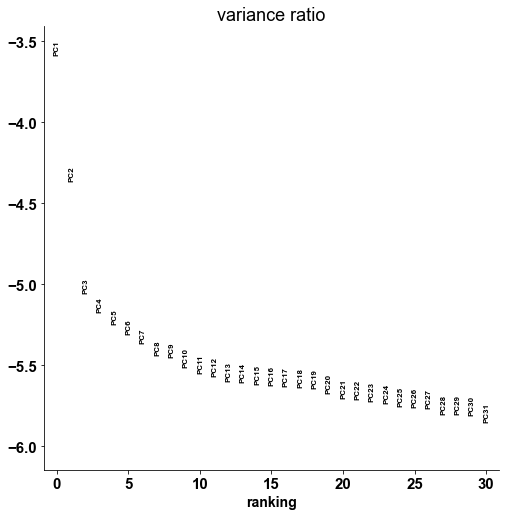

In [58]:
sc.pp.filter_genes(RP_adata, min_cells=3)

sc.pp.normalize_total(RP_adata, target_sum=1e4)

sc.pp.log1p(RP_adata)

sc.pp.highly_variable_genes(RP_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

sc.tl.pca(RP_adata, svd_solver='arpack', use_highly_variable=True)
sc.pl.pca_variance_ratio(RP_adata, log=True)
sc.pp.neighbors(RP_adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(RP_adata)
sc.tl.louvain(RP_adata, resolution=0.6)

In [59]:
RP_adata.obs['Annotation'] = H3K27ac_real.obs['cell_type'][RP_adata.obs.index]
RP_adata.obs['ident'] = H3K27ac_real.obs['cell_type'][RP_adata.obs.index]

In [81]:
RP_adata

AnnData object with n_obs × n_vars = 10414 × 21451
    obs: 'louvain', 'Annotation', 'ident'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'louvain', 'Annotation_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

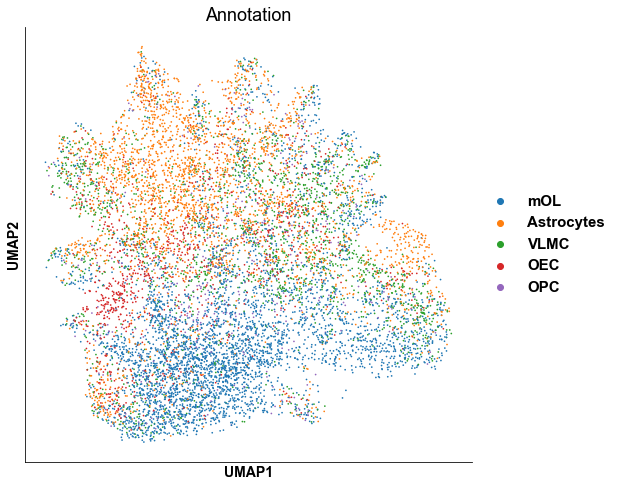

In [74]:
sc.pl.umap(RP_adata, color='Annotation')

In [ ]:
sc.pl.umap(RP_adata, color='NEUROD1',layer='scaled')

In [45]:
sc.tl.rank_genes_groups(RP_adata, 'Annotation')

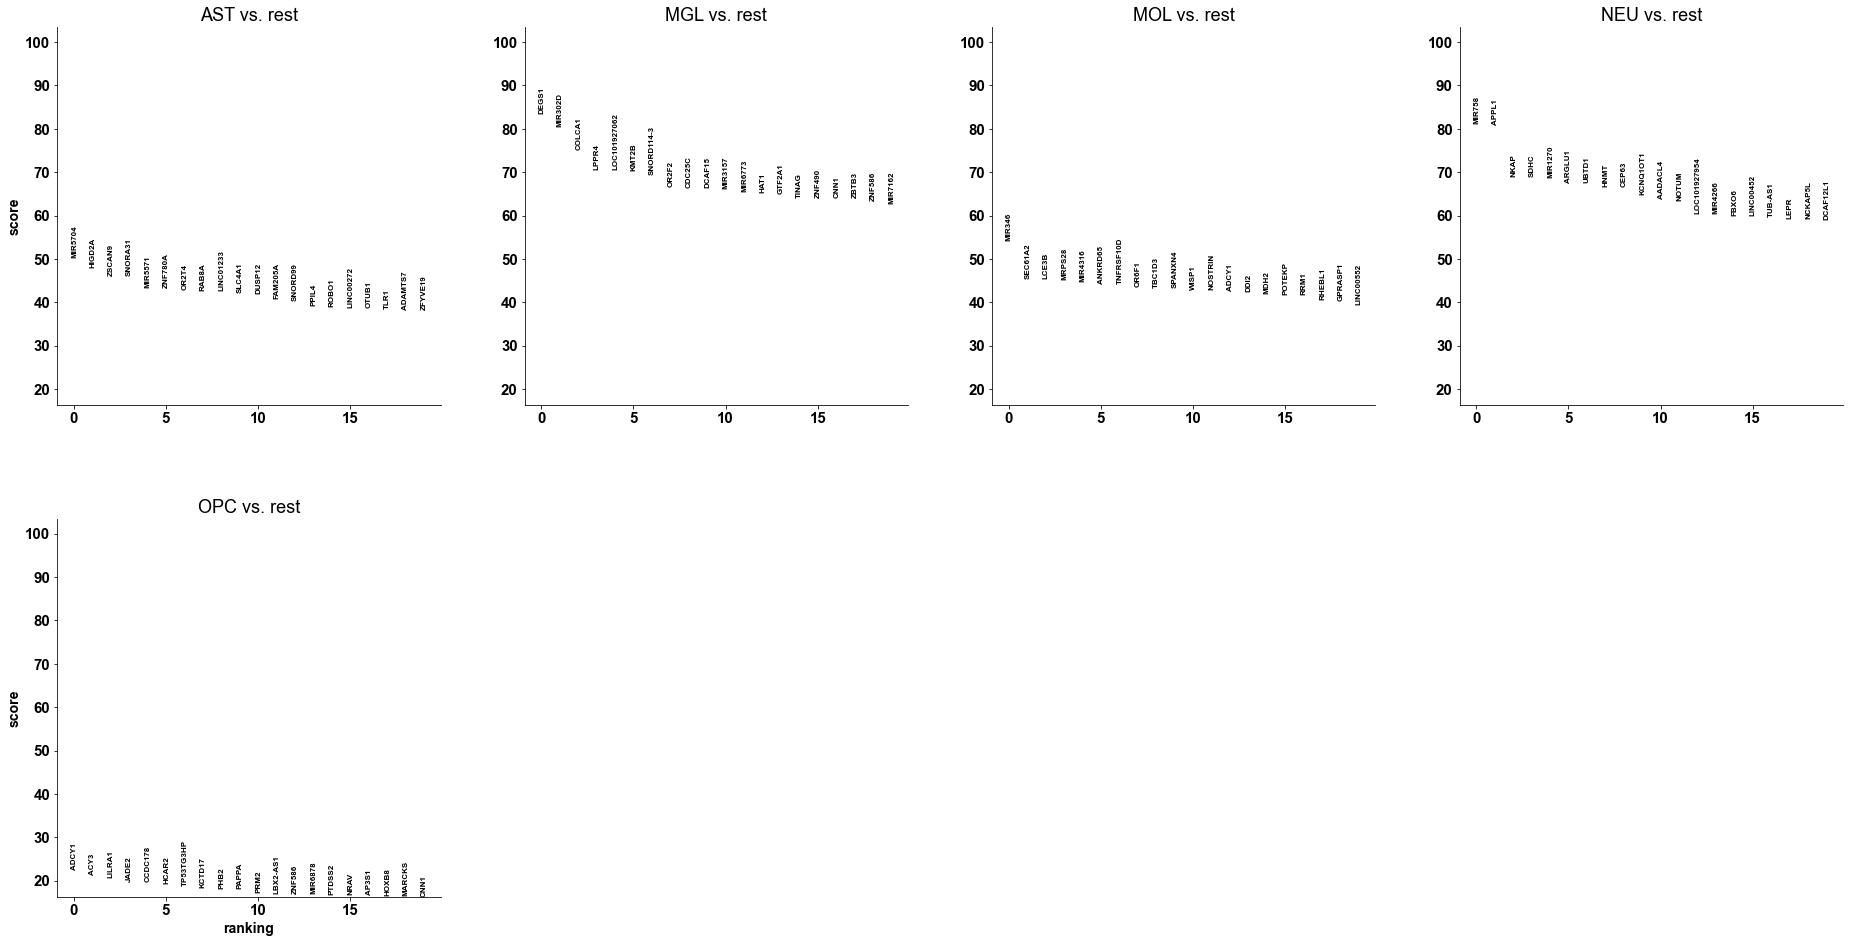

In [46]:
sc.pl.rank_genes_groups(RP_adata)

# H3K27ac

In [75]:
H3K4me1_peaks =  pybedtools.BedTool('\n'.join(['\t'.join(p.rsplit('_', maxsplit=2)) for p in [i.replace('-', '_') for i in H3K4me1.var.index]]), from_string=True)
ATAC_peaks = pybedtools.BedTool('\n'.join(['\t'.join(p.rsplit('_', maxsplit=2)) for p in [i.replace('-', '_') for i in ATAC.var.index]]), from_string=True)

In [ ]:
H3K4me1_peaks.intersect(ATAC_peaks, u=True).to_dataframe()

In [ ]:
atac_v1_adult_brain_fresh_5k_filtered_peak_bc_matrix.h5

In [335]:
ATAC.X

<3814x169121 sparse matrix of type '<class 'numpy.float32'>'
	with 50996381 stored elements in Compressed Sparse Row format>

In [315]:
input_mat_adata = ATAC.copy().X


In [97]:
input_mat_adata.X

<10551x128352 sparse matrix of type '<class 'numpy.float32'>'
	with 5447120 stored elements in Compressed Sparse Row format>

In [95]:
imputed_csr = cal_neighbor_cell_peak_mat_batch(input_mat, impute_n=5, KD_leafsize=80, nPC = 50, n_cores=8)
utils.store_to_pickle(imputed_csr, 'example/histone/peak_base/pairedseq/ATAC_analysis/imputed.csr.pk')

INFO 2021-09-13 15:11:02 Building KD tree...
INFO 2021-09-13 15:11:10 Calculating neighbors, divide into 8 chunks...
INFO 2021-09-13 15:11:27 Finished!


In [98]:
imputed_csr[imputed_csr>1] = 1

In [282]:
input_mat_adata.X = imputed_csr

In [187]:
generate_beds_by_matrix(input_mat_adata, 'example/histone/peak_base/pairedseq/SCRIPT/imputation/imputed_beds/', 'example/histone/peak_base/pairedseq/SCRIPT/imputation/imputed_beds_peaks_number.txt', 16)

In [284]:
search_seqpare_factor_batch('example/histone/peak_base/pairedseq/SCRIPT/imputation/imputed_beds/', 
                            'example/histone/peak_base/pairedseq/SCRIPT/imputation/imputed_results_H3K4me1_5fold/', 
                            '/fs/home/dongxin/Projects/SCRIPT/indices/mouse/hm_chip_qc_5fold',
                           'H3K4me1',
                           16)

INFO 2021-09-14 11:45:03 Start searching beds from  index ...
INFO 2021-09-14 12:03:29 Finished searching beds from  index ...


In [286]:
H3K4me1_affinity = get_factor_affinity(input_mat_adata, 'example/histone/peak_base/pairedseq/SCRIPT/imputation/all_beds.bed', '/fs/home/dongxin/Projects/SCRIPT/indices/mouse/hm_chip_qc_5fold', 'H3K4me1', 339815)

In [287]:
H3K4me1_enrich = read_seqpare_result_batch('example/histone/peak_base/pairedseq/SCRIPT/imputation/imputed_results_H3K4me1_5fold/')

INFO 2021-09-14 12:56:46 Reading searching results, using 8 cores...
INFO 2021-09-14 12:56:53 Finished reading  index search result!


In [289]:
H3K4me1_hyper_bg = cal_peak_factor_norm('/fs/home/dongxin/Projects/SCRIPT/indices/mouse/hm_chip_qc_1_20k/peaks_number.txt', 'example/histone/peak_base/pairedseq/SCRIPT/imputation/imputed_beds_peaks_number.txt', 339815, H3K4me1_affinity, 'H3K4me1')

In [290]:
H3K4me1_score = cal_score(H3K4me1_enrich, H3K4me1_hyper_bg)

In [291]:
ref_peak_number = pd.read_csv('/fs/home/dongxin/Projects/SCRIPT/indices/mouse/hm_chip_qc_5fold/peaks_number.txt', sep='\t', header=None, index_col=0)
factor_idx = [i for i in ref_peak_number.index if i.startswith('H3K4me1')]
ref_peak_number = ref_peak_number.loc[factor_idx,:]
H3K4me1_score = H3K4me1_score.loc[ref_peak_number.index[ref_peak_number[1] > 5000],:].copy()

In [292]:
H3K4me1_source = get_factor_source(H3K4me1_score)

INFO 2021-09-14 12:58:11 Getting the best reference for each cell.


In [293]:
H3K4me1_source.loc['H3K4me1',:].unique()

array(['H3K4me1_38349', 'H3K4me1_54605', 'H3K4me1_33397'], dtype=object)

In [ ]:
H3K4me1_source.T

In [295]:
ref_path = '/fs/home/dongxin/Projects/SCRIPT/indices/mouse/hm_chip_qc_5fold/'
chip_bed_list = [pybedtools.BedTool(os.path.join(ref_path, i + '.bed.gz')) for i in H3K4me1_source.iloc[0,:].unique()]
chip_bed = chip_bed_list[0].cat(*chip_bed_list[1:])
print(chip_bed.__len__())

170841


In [296]:
data_bed = pybedtools.BedTool('\n'.join(['\t'.join(p.rsplit('_', maxsplit=2)) for p in input_mat_adata.var_names]), from_string=True)
intersect_bed = data_bed.intersect(chip_bed, u=True)
imputed_chip_peak = str(intersect_bed).replace('\t','_').split('\n')[0:-1]

In [297]:
chip_cell_peak = input_mat_adata[:,imputed_chip_peak].copy()

In [298]:
chip_cell_peak_df = chip_cell_peak.to_df()

In [299]:
chip_cell_peak_df.max().max()

1.0

In [214]:
# for i in H3K4me1_source.iloc[0,:].unique():
#     cellbc = H3K4me1_source.columns[H3K4me1_source.iloc[0,:] == i]
#     tmp_dataset_bed = pybedtools.BedTool(os.path.join(ref_path, i + '.bed.gz'))
# #     print(str(intersect_bed.intersect(tmp_dataset_bed)).replace('\t','_').split('\n')[0:-1].__len__())
#     exclude_chip_peak = str(intersect_bed.intersect(tmp_dataset_bed, v=True)).replace('\t','_').split('\n')[0:-1]
# #     ovlp = 441896 - exclude_chip_peak.__len__()
# #     print(i)
# #     print(H3K4me1_source.columns[H3K4me1_source.iloc[0,:] == i].__len__())
# #     print(ovlp)
#     chip_cell_peak_df.loc[cellbc,exclude_chip_peak] = 0

In [300]:
chip_cell_peak_df.sum(1).sort_values()

52:64:65:01     168.0
52:78:26:01     170.0
52:59:16:01     170.0
52:68:26:01     177.0
52:77:07:01     177.0
                ...  
56:22:05:10    4082.0
55:92:10:10    4217.0
53:45:45:10    4516.0
53:62:05:05    5084.0
51:69:63:01    5409.0
Length: 10551, dtype: float32

In [301]:
chip_cell_peak = sc.AnnData(chip_cell_peak_df)

In [302]:
chip_cell_peak.X = scipy.sparse.csr.csr_matrix(chip_cell_peak.X)

In [303]:
chip_cell_peak.X[chip_cell_peak.X>1] = 1

In [304]:
def write_to_mtx(data, path):
    if not os.path.exists(path):
        os.makedirs(path)
    pd.DataFrame(data.var.index).to_csv(os.path.join(path, "genes.tsv" ), sep = "\t", index=False, header=False)
    pd.DataFrame(data.obs.index).to_csv(os.path.join(path, "barcodes.tsv"), sep = "\t", index=False, header=False)
    data.obs.to_csv(os.path.join(path, "metadata.tsv"), sep = "\t", index=False, header=False)
    io.mmwrite(os.path.join(path, "matrix.mtx"), data.X.T)

In [305]:
write_to_mtx(chip_cell_peak, 'example/histone/peak_base/pairedseq/SCRIPT/imputation/mtx_imputed_H3K4me1/')

In [207]:
chip_cell_peak

AnnData object with n_obs × n_vars = 10551 × 6978

In [18]:
H3K27ac_real.X

<10414x84989 sparse matrix of type '<class 'numpy.float32'>'
	with 3856187 stored elements in Compressed Sparse Row format>

# H3K4me1

In [212]:
H3K4me1 = utils.read_SingleCellExperiment_rds('example/histone/peak_base/H3K4me1/H3K4me1_analysis/H3K4me1_SE.rds')
H3K4me1.var.index = [i.replace('-', '_') for i in H3K4me1.var.index]
H3K4me1.obs['Annotation'] = metadata['CellType'][H3K4me1.obs.index]
H3K4me1.obs['Tissue'] = metadata['Tissue'][H3K4me1.obs.index]

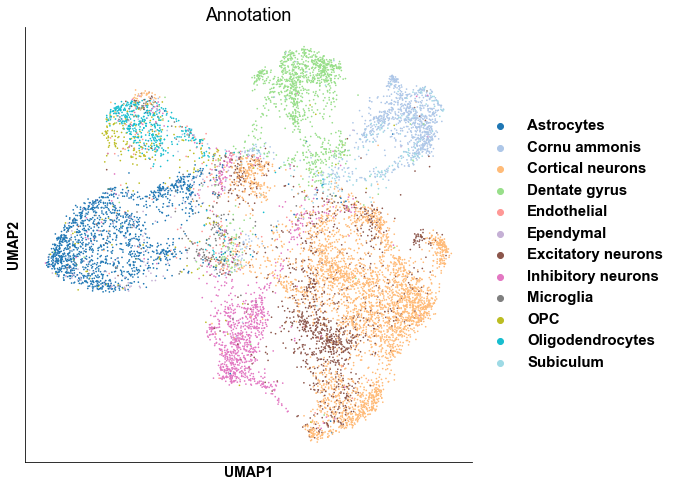

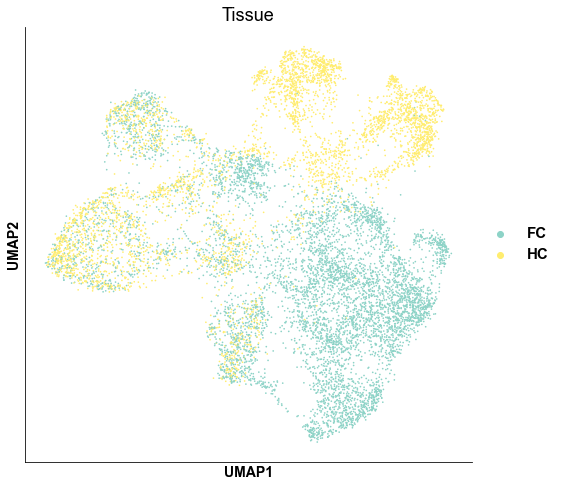

In [88]:
sc.pl.umap(H3K4me1, color='Annotation', palette='tab20')
sc.pl.umap(H3K4me1, color='Tissue', palette='Set3')

In [ ]:
H3K4me1_source.T['H3K4me1'][H3K4me1_impute.obs.index]

In [306]:
H3K4me1_impute = utils.read_SingleCellExperiment_rds('example//histone//peak_base/pairedseq/SCRIPT/imputation//H3K4me1_imputation_analysis/H3K4me1_imputation_SE.rds')
H3K4me1_impute.var.index = [i.replace('-', '_') for i in H3K4me1_impute.var.index]
H3K4me1_impute.obs['Annotation'] = metadata['CellType'][H3K4me1_impute.obs.index]
H3K4me1_impute.obs['Tissue'] = metadata['Tissue'][H3K4me1_impute.obs.index]
H3K4me1_impute.obs['Source'] = H3K4me1_source.T['H3K4me1'][H3K4me1_impute.obs.index]

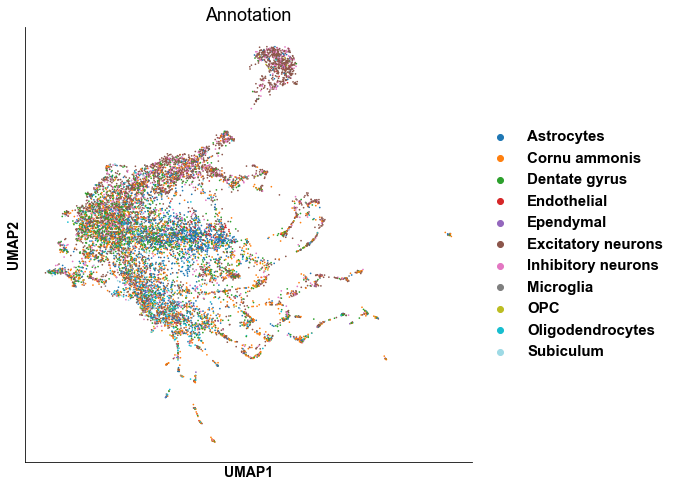

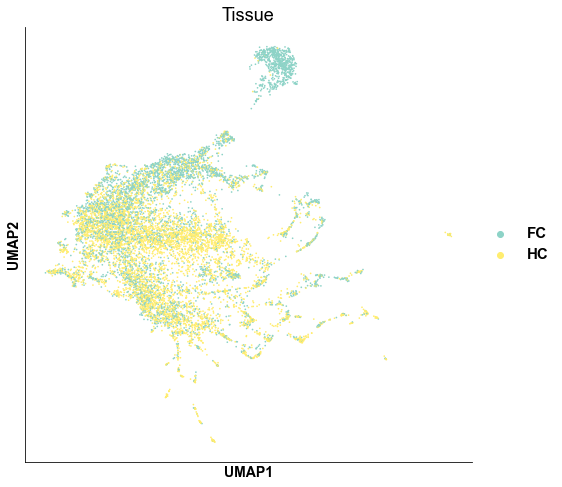

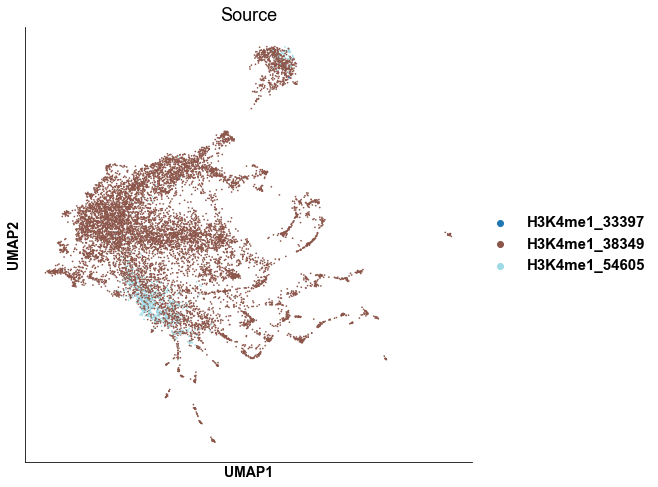

In [308]:
sc.pl.umap(H3K4me1_impute, color='Annotation', palette='tab20')
sc.pl.umap(H3K4me1_impute, color='Tissue', palette='Set3')
sc.pl.umap(H3K4me1_impute, color='Source', palette='tab20')

## PAIRED-tag ATAC (PAIRED-seq V2)

In [318]:
# metadata = pd.read_csv('example/histone/bin_base/matrix/meta.tsv', sep='\t', index_col = 0)

# replace_dict = {
#     'Astro_Myoc': 'Astrocytes',
#     'Astro_Nnat': 'Astrocytes',
#     'L5': 'Excitatory neurons', 
#     'L23': 'Excitatory neurons',
#     'L6': 'Excitatory neurons', 
#     'L4': 'Excitatory neurons',
#     'NP': 'Excitatory neurons', 
#     'CT': 'Excitatory neurons', 
#     'PT': 'Excitatory neurons', 
#     'DG': 'Dentate gyrus', 
#     'CA1': 'Cornu ammonis', 
#     'CA23': 'Cornu ammonis', 
#     'Subiculum': 'Subiculum', 
#     'Pvalb': 'Inhibitory neurons',
#     'CGE': 'Inhibitory neurons',
#     'Sst': 'Inhibitory neurons',
#     'Microglia': 'Microglia',
#     'OPC': 'OPC', 
#     'Ependymal': 'Ependymal',
#     'Endothelial': 'Endothelial',
#     'Oligo_MOL': 'Oligodendrocytes', 
#     'Oligo_MFOL': 'Oligodendrocytes'
# }

# metadata['CellType'] = [replace_dict[i] for i in metadata['Annotation']]

In [ ]:
ATAC = utils.read_SingleCellExperiment_rds('example/histone/peak_base/pairedtag/ATAC_analysis/ATAC_SE.rds')
ATAC.var.index = [i.replace('-', '_') for i in ATAC.var.index]
ATAC.obs['Annotation'] = metadata['CellType'][ATAC.obs.index]
# ATAC.obs['Annotation'] = metadata['CellType'][ATAC.obs.index]

In [ ]:
sc.pl.umap(ATAC, color='Annotation', palette='tab20')
# sc.pl.umap(ATAC, color='Tissue', palette='Set3')

## PAIRed-seq ATAC (V1)

In [ ]:
# metadata = pd.read_csv('example/histone/data/ATAC/Adult_Cerebrail_Cortex/Cell_embeddings.xls', sep='\t', index_col = 0)

# replace_dict = {
#     1: 'AS',
#     2: 'MG',
#     3: 'OC', 
#     4: 'Ex1',
#     5: 'Ex2', 
#     6: 'Ex3',
#     7: 'ln1', 
#     8: 'ln2', 
#     9: 'ln3'
# }

# metadata['CellType'] = [replace_dict[i] for i in metadata['Cluster']]

# metadata